In [1]:
!pip install dionysus
!pip install gudhi
!pip install zarr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dionysus: filename=dionysus-2.0.10-cp310-cp310-linux_x86_64.whl size=440652 sha256=f55df693273ef3da0b929d6bffa2f1f6c16e5f4217bae5332c6b2769c523c40d
  Stored in directory: /root/.cache/pip/wheels/1d/8f/2a/22f69fac8dab81069f0501bdd69961a69e82b8b3007f191a15
Successfully built dionysus
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.1/206.1 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 92.7 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=4afa69e0994121f0652c13f5e1fa677c344e6e3d7ba4c21324f6d33cbf973a69
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [2]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive',force_remount=True)

import os
os.chdir("/content/drive/My Drive/NASA/Fire Detection")
!ls -ltr

Mounted at /content/drive
total 12
drwx------ 2 root root 4096 Jun  6 00:50 'zzpd fire data'
drwx------ 2 root root 4096 Jun  9 01:01 'zzpd fire data 2'
drwx------ 2 root root 4096 Jul  6 01:45 'zzpd fire data 3'


In [3]:
import numpy as np
import dionysus as d
import matplotlib.pyplot as plt

In [4]:
#fname = 'zzpd fire data 2' # old dataset
fname = 'zzpd fire data 3'
rawFileList = os.listdir(fname)
print (rawFileList)
print (len(rawFileList))

['Tile_1_33_20201501711176.zarr', 'Tile_1_33_20201501801176.zarr', 'Tile_1_33_20201511406176.zarr', 'Tile_1_33_20201501811176.zarr', 'Tile_1_33_20201501701176.zarr', 'Tile_1_33_20201501756176.zarr', 'Tile_1_33_20201511436176.zarr', 'Tile_1_33_20201511416176.zarr', 'Tile_1_33_20201491716176.zarr']
9


In [5]:
import zarr

In [6]:
channel7List = []
channel7Name = []
timeSeriesDict = {}

rawFileList = sorted(rawFileList)

for name in rawFileList:
    channelData = np.array(zarr.open(fname + '//' + name)[:, :, 0]) # select channel 7
    timeSeriesDict[name] = channelData
    channel7List.append(channelData)
    channel7Name.append(name)

print (len(channel7List))

9


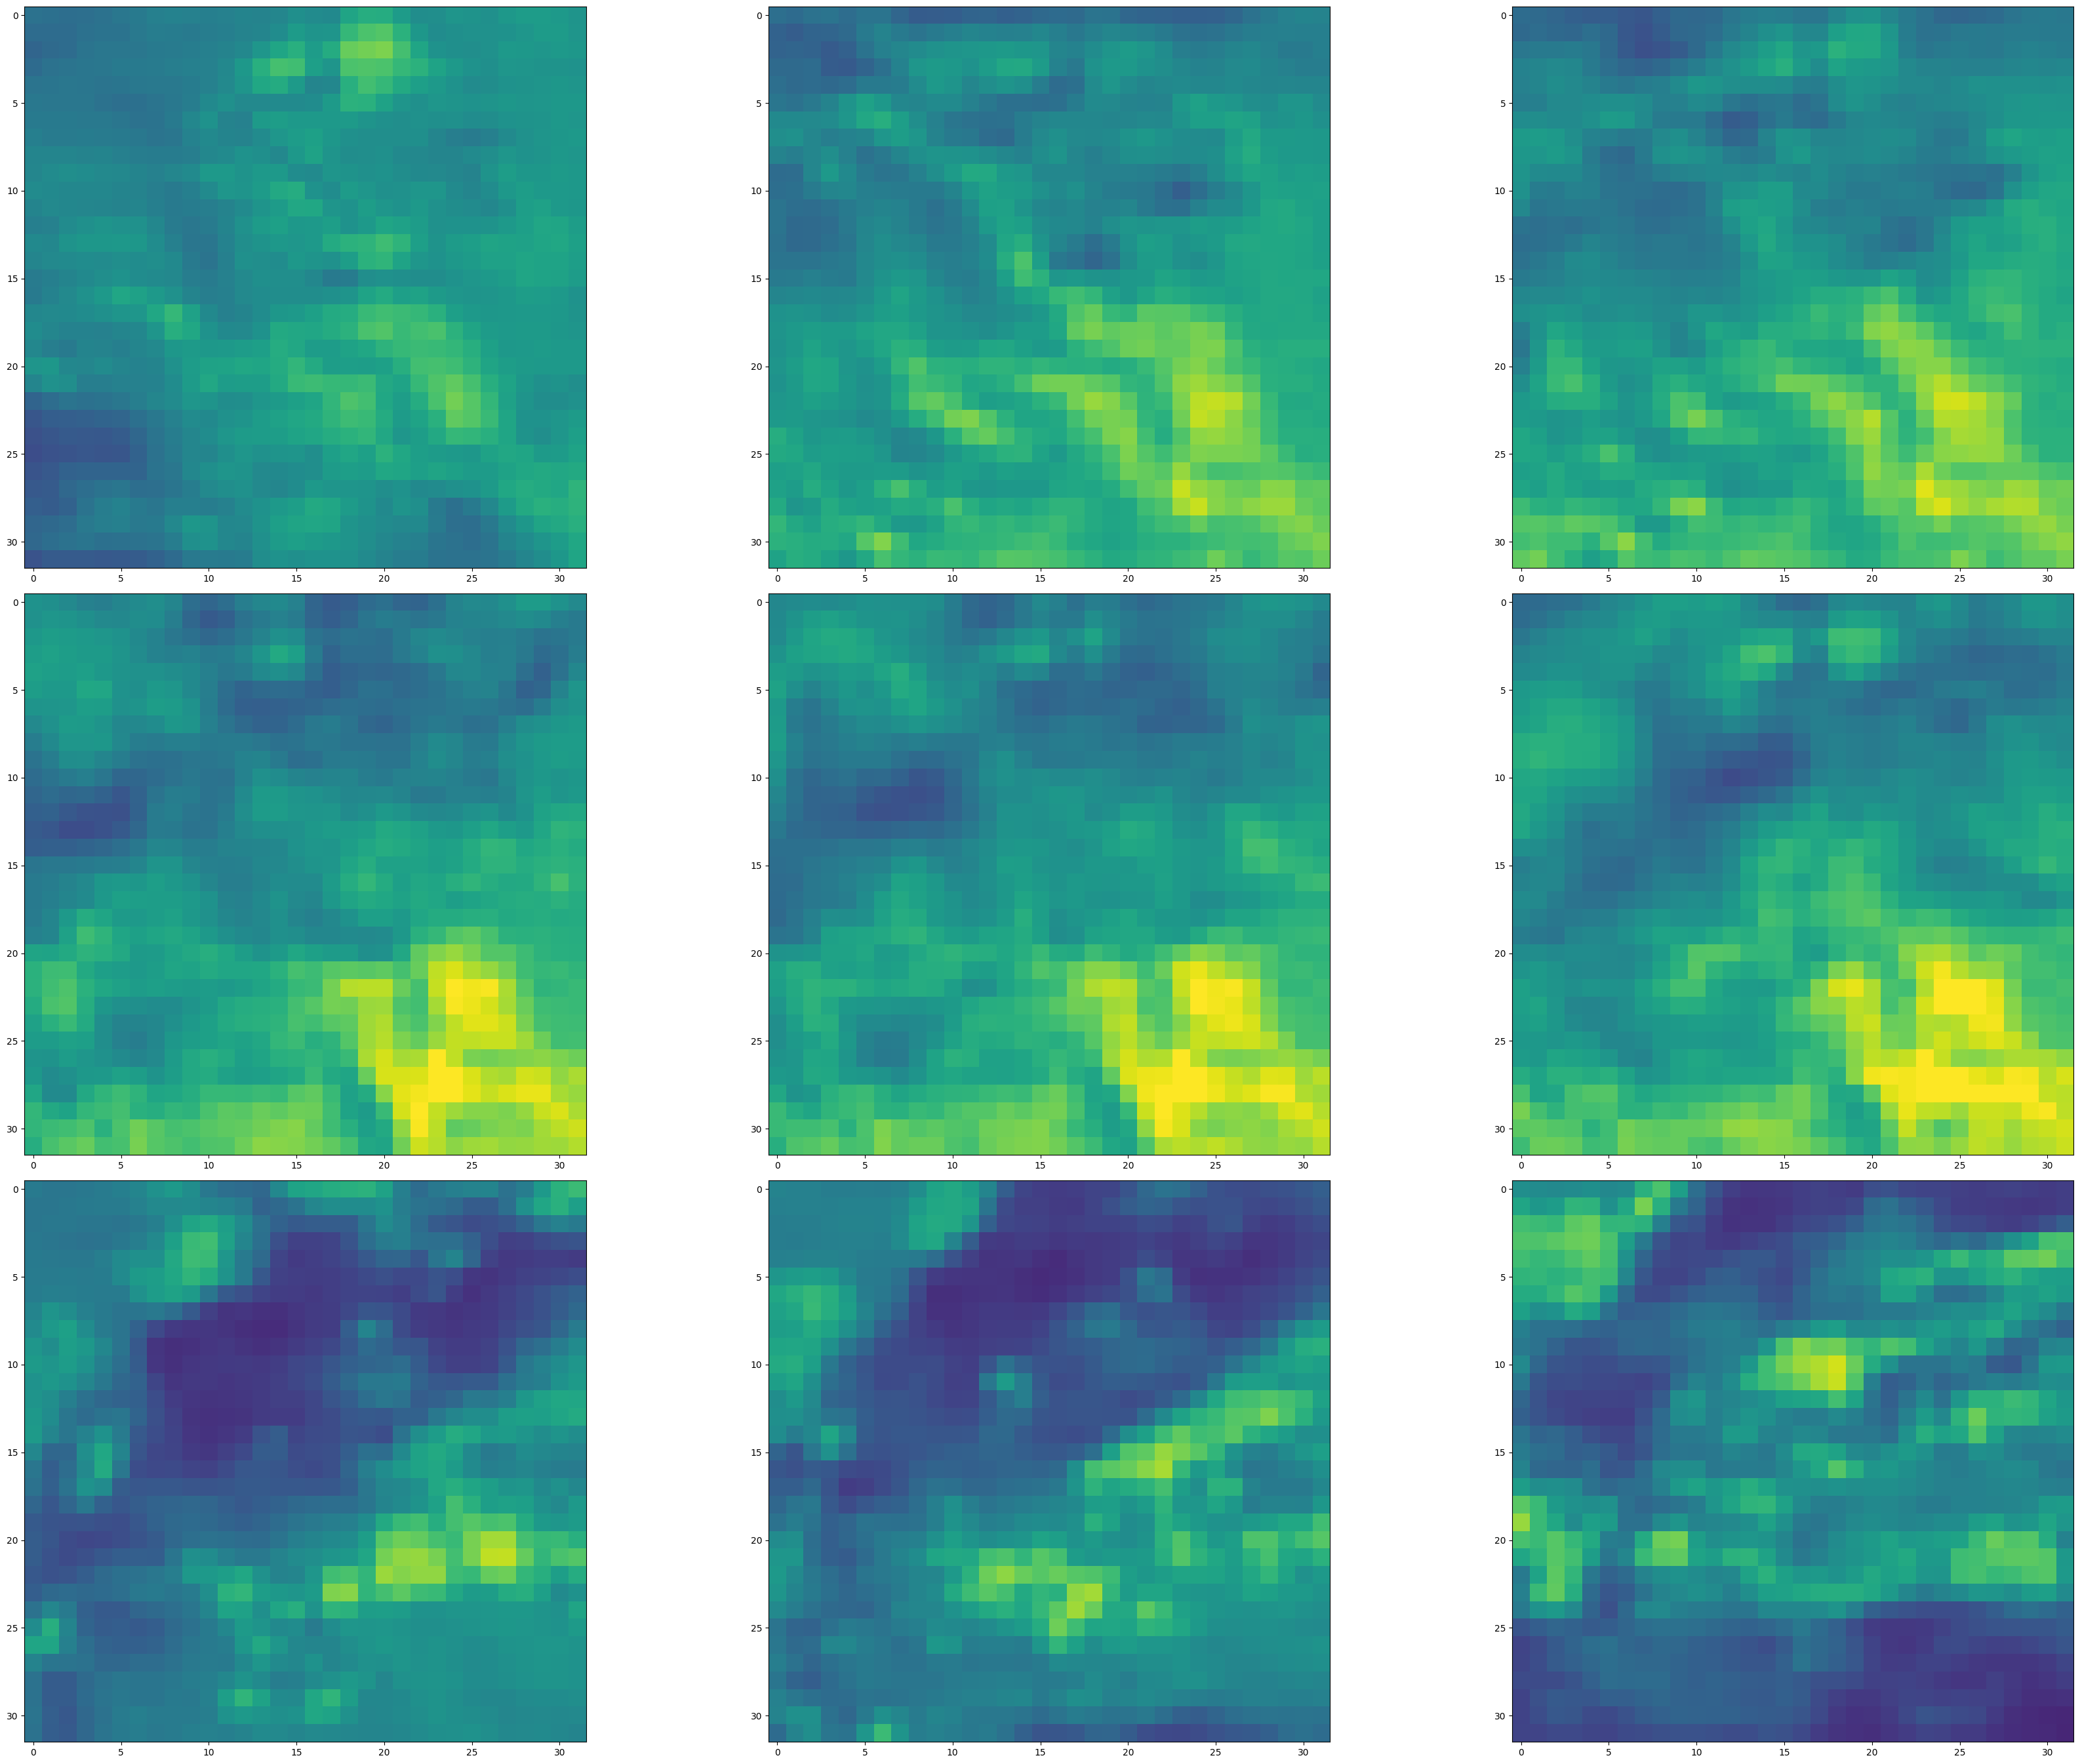

In [7]:
#nrow = 2 # old data
#ncol = 4

nrow = 3
ncol = 3

fig, axs = plt.subplots(nrow, ncol, figsize=(36, 27))

for i in range(nrow):
    for j in range(ncol):
        axs[i, j].imshow(channel7List[i* ncol + j], vmin=0, vmax=1) # vmin, vmax may change on different tiles
        #label = dfLabel.loc[dfLabel['fname'] == channel7Name[i* 6 + j], 'fire'].iloc[0]
        #axs[i, j].title.set_text('Label {}'.format(label))

plt.tight_layout()

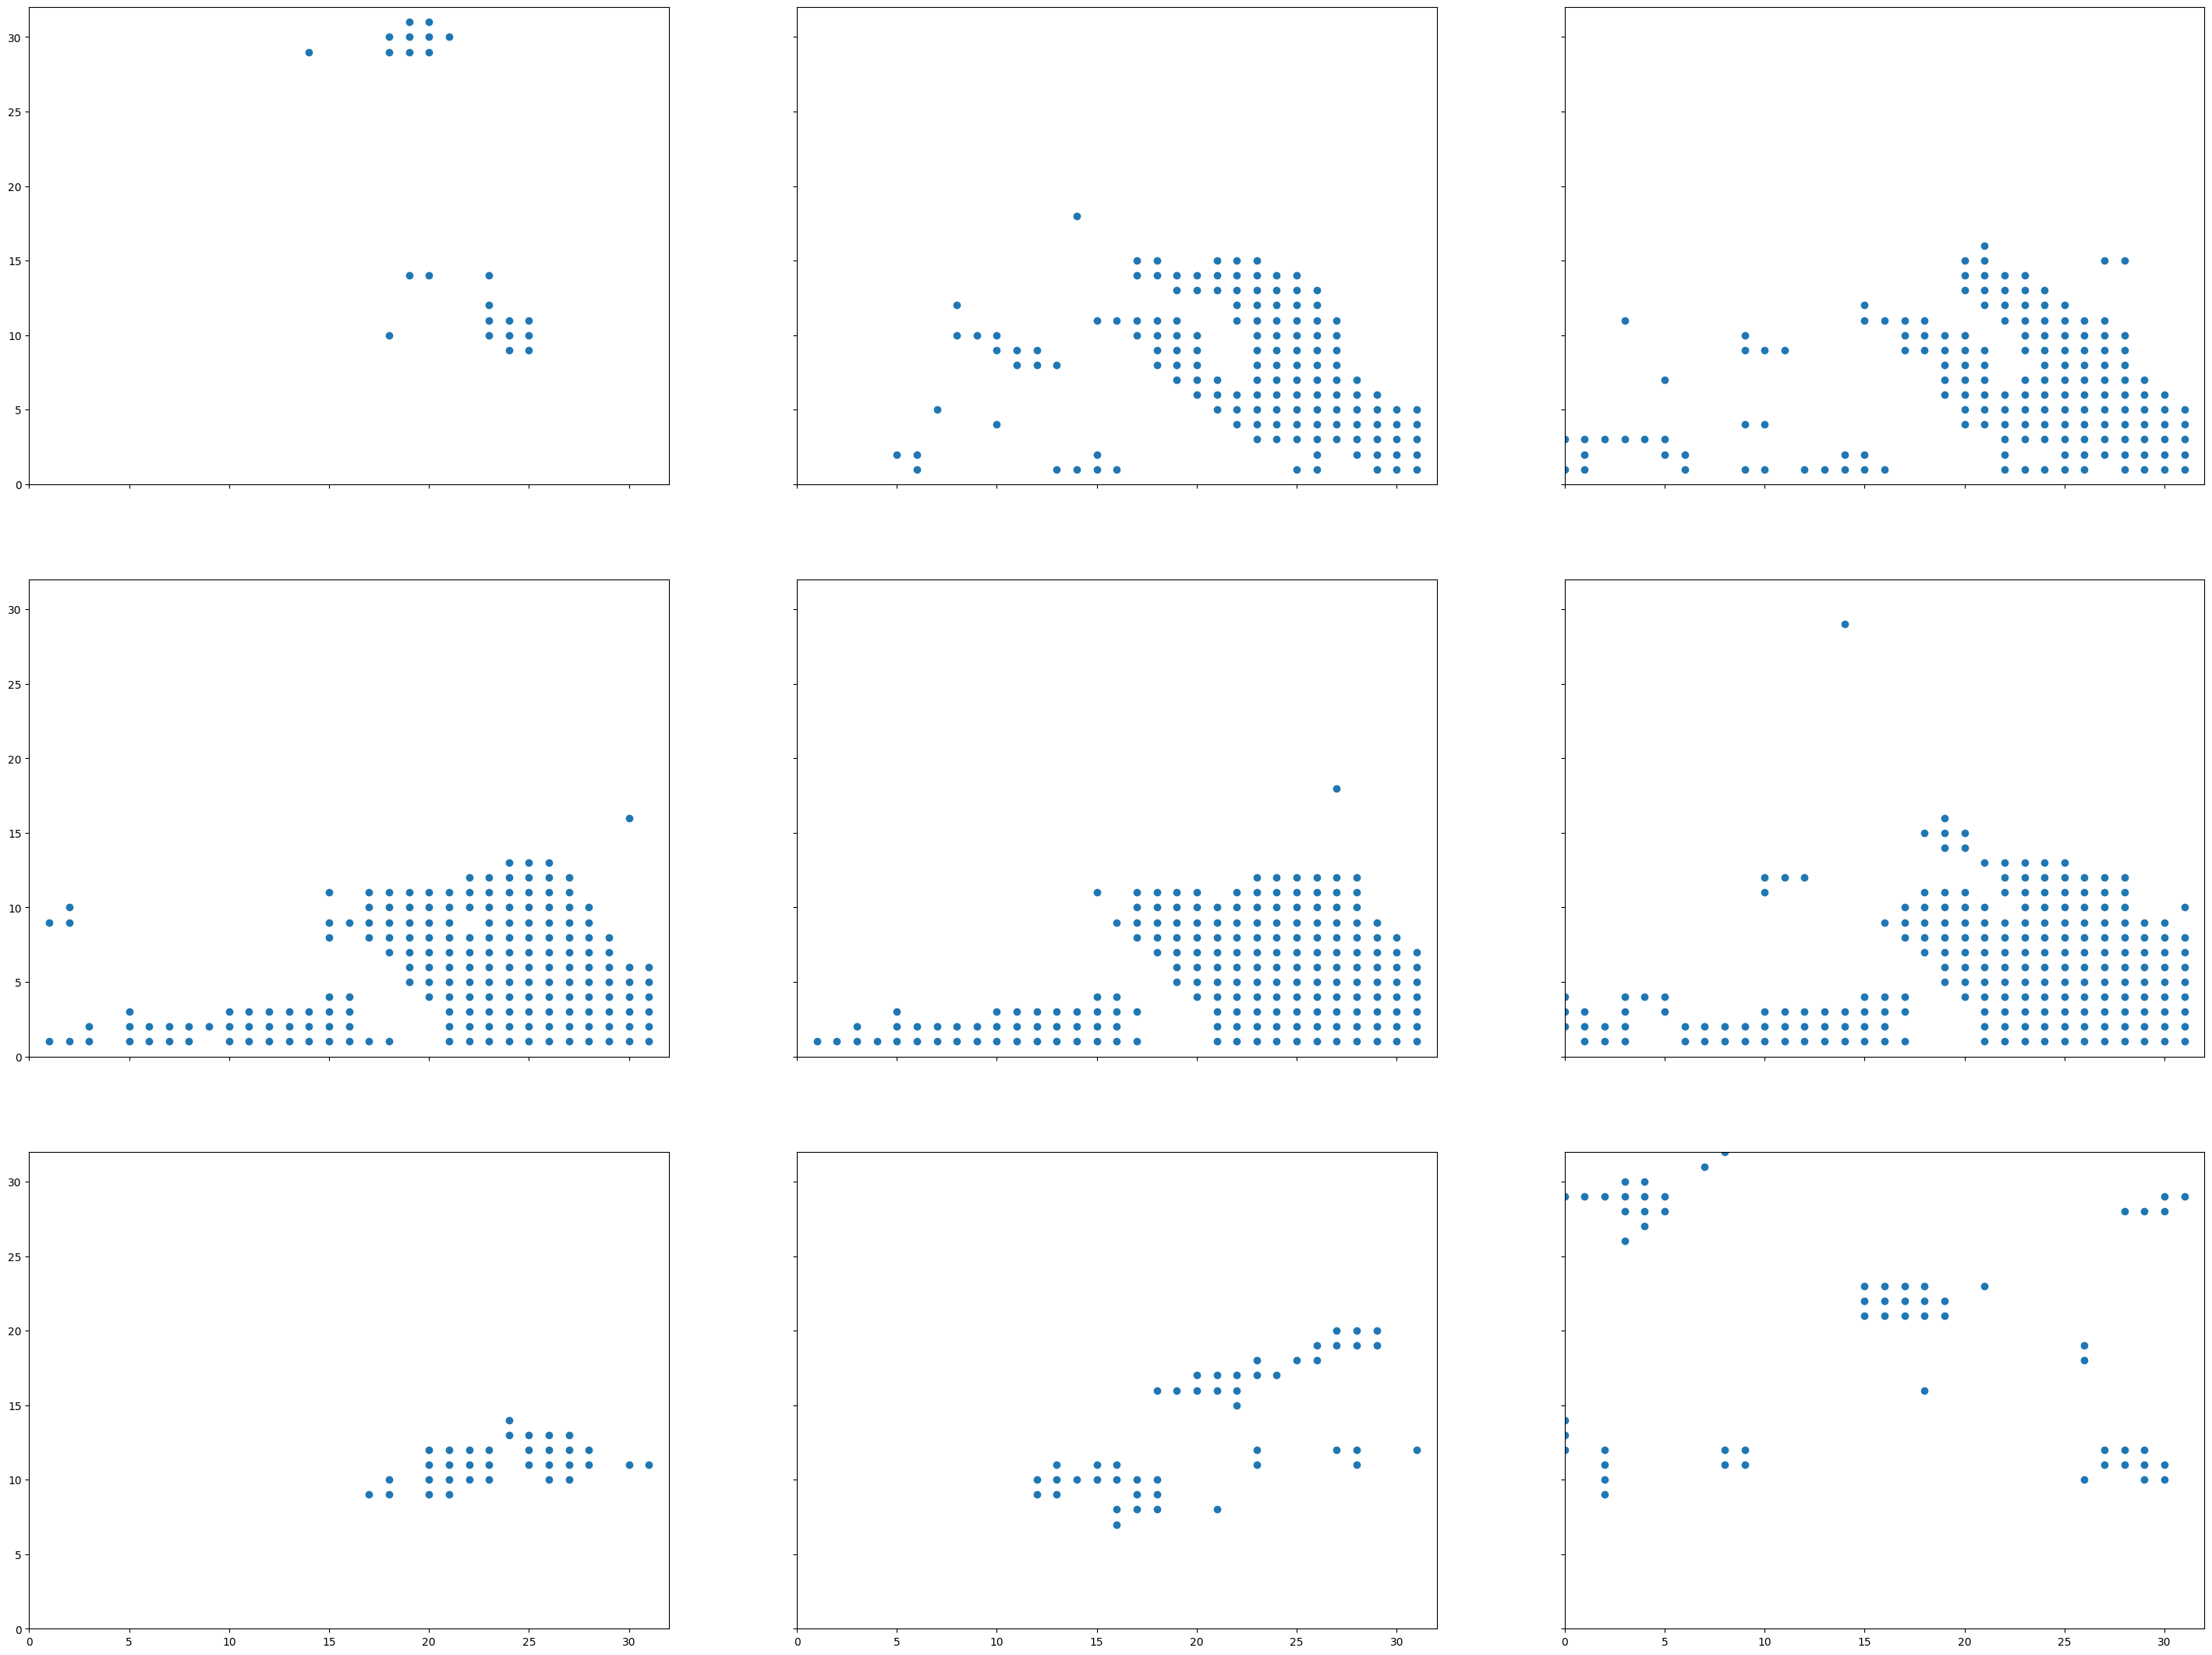

In [8]:
subLevel = 0.7

fig, ax = plt.subplots(nrow, ncol, sharex='col', sharey='row', figsize=(36, 27))
for i in range(0, nrow):
    for j in range(0, ncol):
        pointcloud = np.argwhere(np.array(channel7List[i*ncol + j]) > subLevel)
        x = pointcloud[:, 1]
        y = 32 - pointcloud[:, 0]
        ax[i, j].scatter(x, y)
        ax[i, j].set_xlim([0, 32])
        ax[i, j].set_ylim([0, 32])
plt.show()

In [9]:
def removeInnerPoint(ptCld): # input numpy array
    ptCldList = ptCld.tolist()
    removeList = []
    for pt in ptCldList:
        left = [pt[0], pt[1] - 1]
        right = [pt[0], pt[1] + 1]
        top = [pt[0] - 1, pt[1]]
        bottom = [pt[0] + 1, pt[1]]
        if (left in ptCldList) and (right in ptCldList) and (top in ptCldList) and (bottom in ptCldList):
            removeList.append(pt)

    for removePt in removeList:
        ptCldList.remove(removePt)
    return np.array(ptCldList)

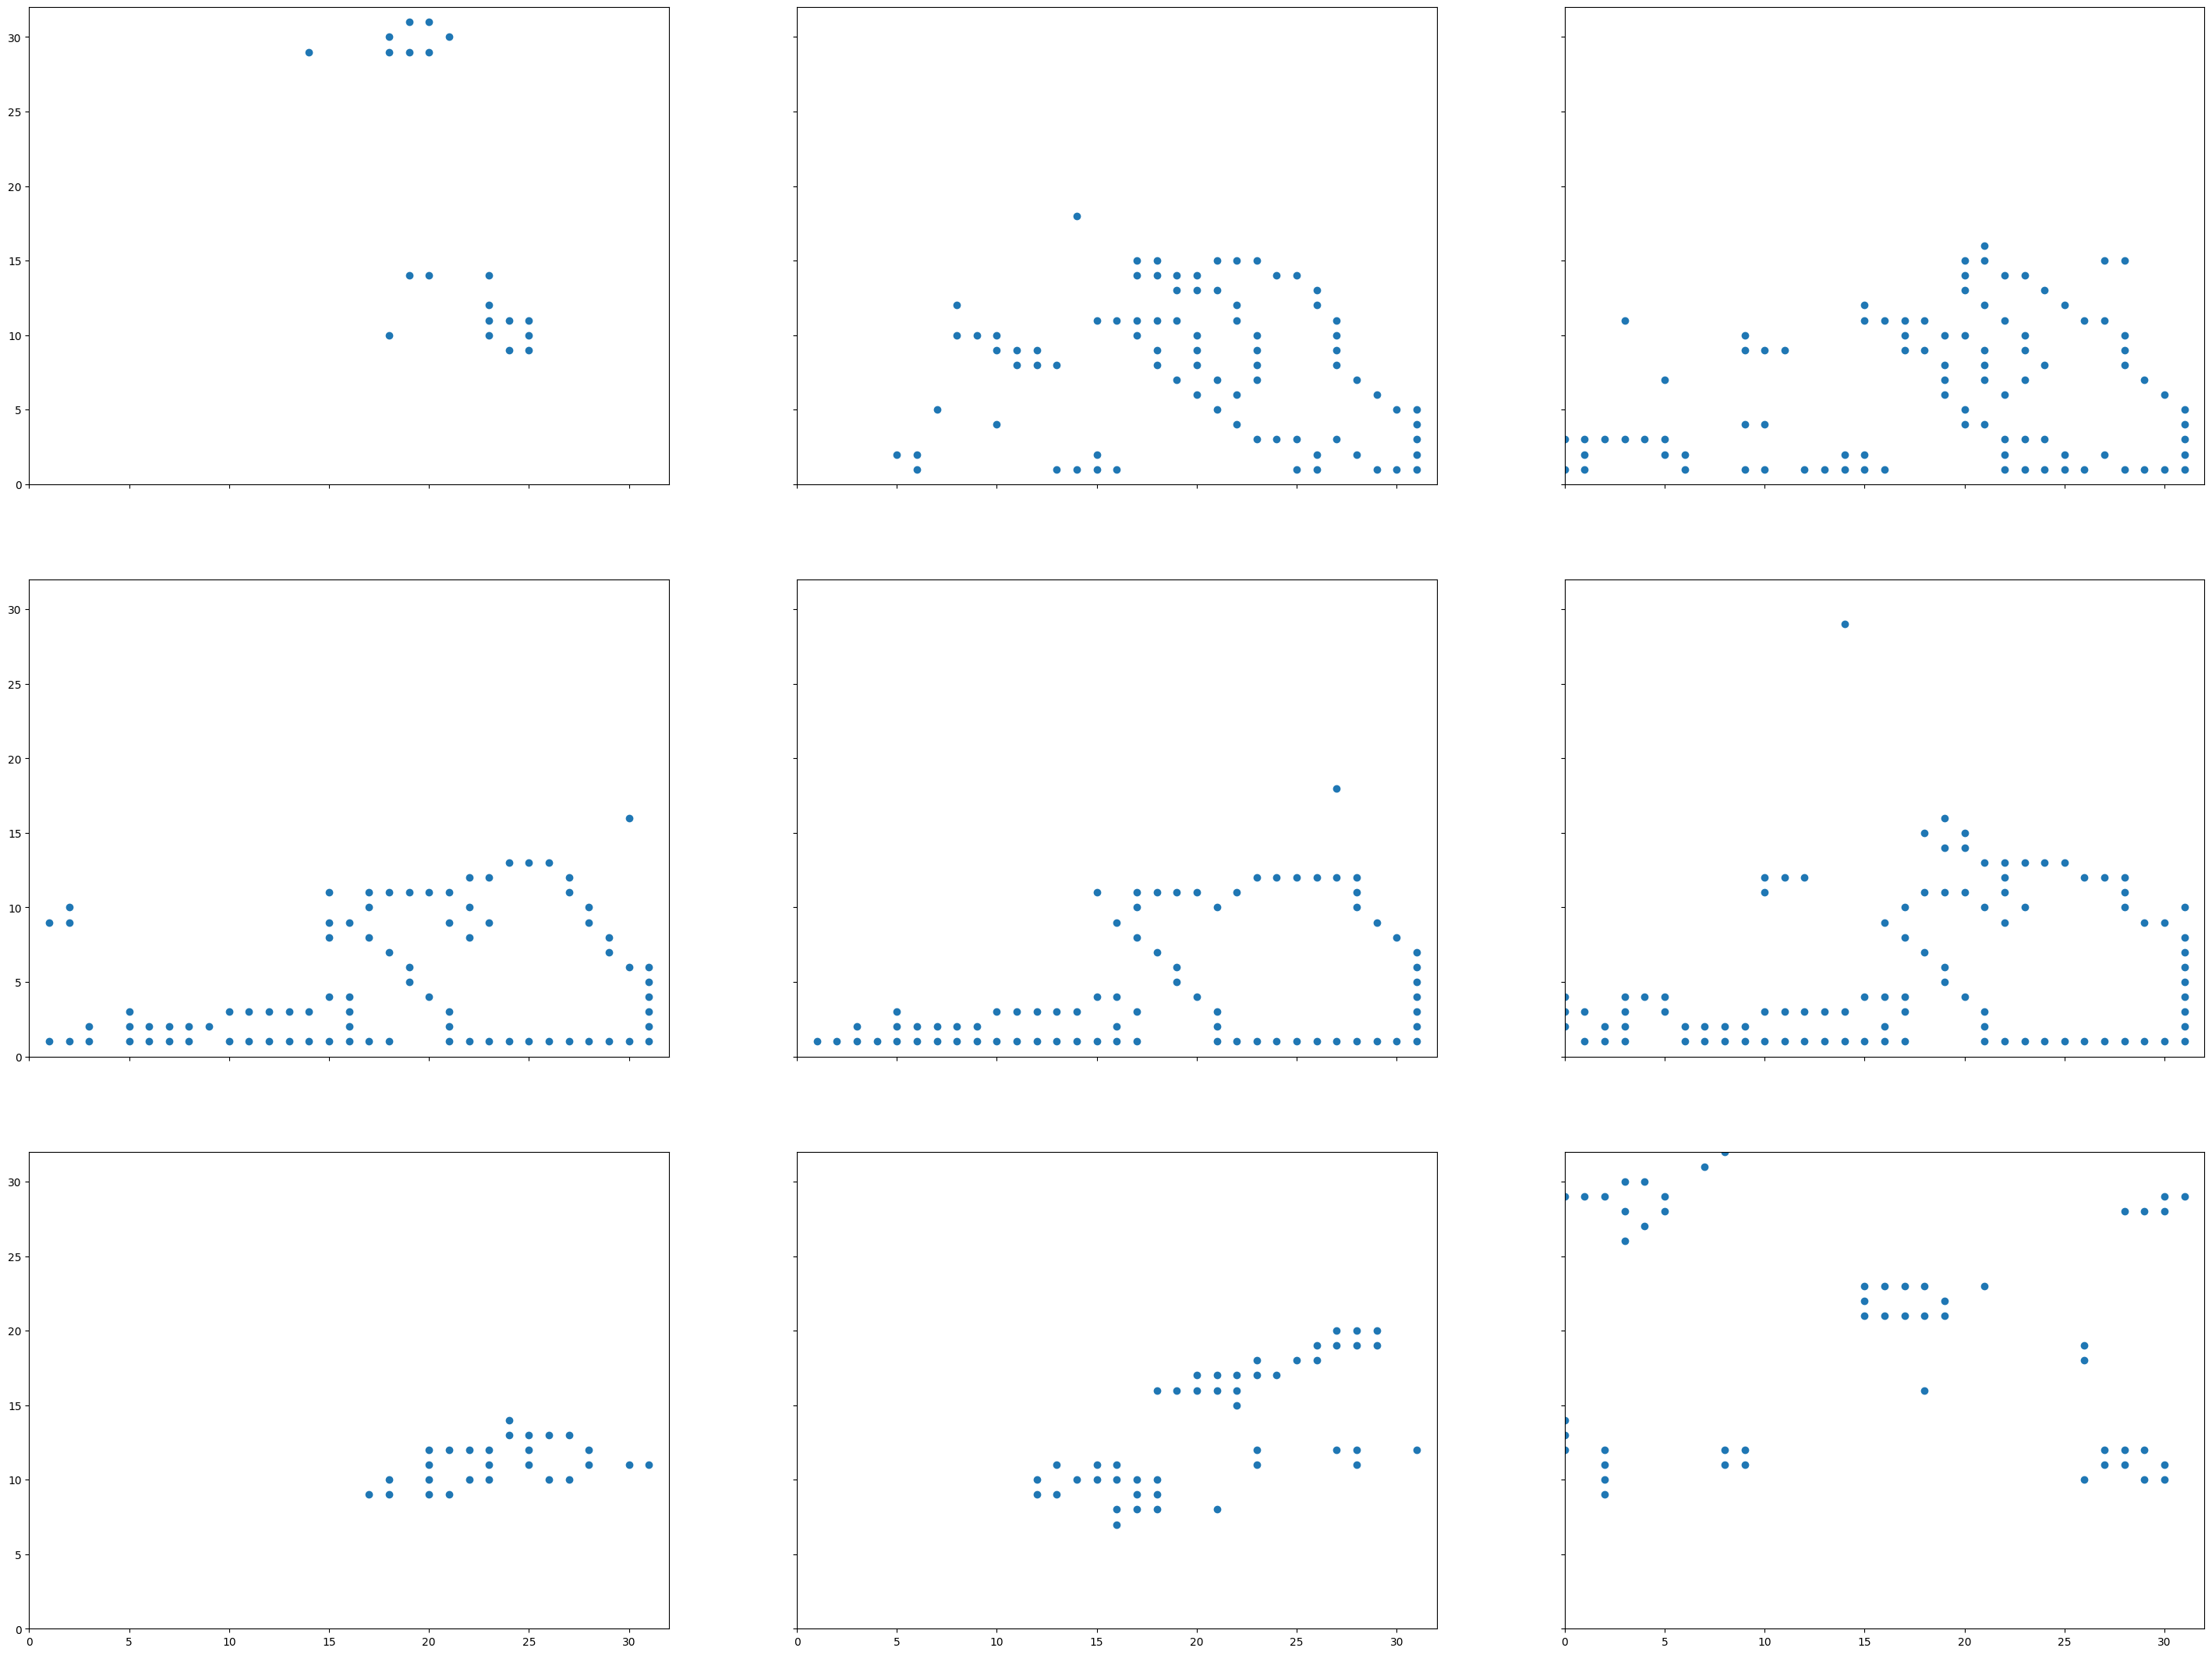

In [10]:
fig, ax = plt.subplots(nrow, ncol, sharex='col', sharey='row', figsize=(36, 27))

zigzagDataList = []
for i in range(0, nrow):
    for j in range(0, ncol):
        pointcloud = np.argwhere(np.array(channel7List[i*ncol + j]) > subLevel)
        newPtCld = removeInnerPoint(pointcloud)
        if newPtCld.size == 0:
            x = [0]
            y = [0]
            newPtCld = np.array([[0, 0]])
        else:
            x = newPtCld[:, 1]
            y = 32 - newPtCld[:, 0]
        zigzagDataList.append(newPtCld)
        ax[i, j].scatter(x, y)
        ax[i, j].set_xlim([0, 32])
        ax[i, j].set_ylim([0, 32])

plt.show()

In [11]:
print (len(zigzagDataList))

9


In [12]:
import collections

In [13]:
def shift_filtration(rips,n):
    "Take a Dionysus filtration and increase the name of all of the vertices by n."
    f = d.Filtration()
    for s in rips:
        dim = s.dimension()
        temp = []
        for i in range(0,dim+1):
            temp.append(s[i]+n)
        f.append(d.Simplex(temp,s.data))
    return f

def get_verts(simp):
    if simp.dimension == 2:
        return [d.Simplex([v], 0) for v in t]
    else:
        return set([s for s in simp.boundary()])

tempPtCldLengthList = []
for i in zigzagDataList:
    tempPtCldLengthList.append(len(i))
ptCldLengthList = np.cumsum(tempPtCldLengthList).tolist()
ptCldLengthList.insert(0, 0)
ptCldLengthList = np.array(ptCldLengthList)

def setup_Zigzag_fixed(lst, r, r_union, verbose=False):

    simps_list = []
    times_list = []

    # Initialize A with R(X_0)
    rips = d.fill_rips(lst[0].astype(np.float32), 1, r)
    for s in rips:
        s.data = 0.0
    rips.sort()
    rips_set = set(rips)

    # Initialize A with set of simplices with verts in X_0
    A = rips_set
    print ('A:{}'.format(A))

    # # Add all simps to the list with birth,death=[0,1]
    simps_list = simps_list + [s for s in A]
    times_list = times_list + [[0, 1] for j in range(len(A))]

    for i in range(1, len(lst)):
        print ('Working on number {}'.format(i))
        # Calculate rips of X_{i-1} \cup X_i

        rips = d.fill_rips(np.vstack([lst[i-1], lst[i]]).astype(np.float32), 2, r_union)
        rips = shift_filtration(rips, ptCldLengthList[i-1])
        for s in rips:
            s.data = 0.0

        # Set of vertices in R(X_i)
        B = d.fill_rips(lst[i].astype(np.float32), 1, r)
        for s in B:
            s.data = 0.0
        B = set(shift_filtration(B, ptCldLengthList[i]))
        print ('B:{}'.format(B))

        # Set of simplices with verts in X_{i-1} AND X_{i}
        M = set()

        # Loop over vertices in R(X_{i-1} \cup R_i)
        for simp in rips:

            # Get list of vertices of simp
            bdy = get_verts(simp)
            #print ('simp: {}'.format(simp))
            #print ('body:{}'.format(bdy))
            #print ('Simplex {} has vertices {}'.format(simp, bdy))
            # If it has no boundary and its in B, its a vertex in B and has been handled
            if simp in A:
                continue

            elif simp in B:
                continue

            else:
                if simp not in simps_list:
                    M.add(simp)

        # Add simplices in B with the corresponding birth,death times
        simps_list = simps_list + [s for s in B]
        times_list = times_list + [[i-0.5, i+1] for j in range(len(B))]

        # Add simplicies in M with corresponding birth,death times
        simps_list = simps_list + [s for s in M]
        times_list = times_list + [[i-0.5, i] for j in range(len(M))]

        # Reinitialize for next iteration
        A = B

    filtration = d.Filtration(simps_list)

    print ('length of time list: {}'.format(len(times_list)))
    print ('length of simp list: {}'.format(len(simps_list)))
    print ('length of filtration: {}'.format(len(filtration)))
    print ('length of simp set: {}'.format(len(set(simps_list))))
    print([item for item, count in collections.Counter(simps_list).items() if count > 1])

    return filtration, times_list

In [14]:
filtration, times_list = setup_Zigzag_fixed(zigzagDataList, 3, 3)
zz, dgms, cells = d.zigzag_homology_persistence(filtration, times_list)

A:{<17,18> 0, <16,19> 0, <1,7> 0, <17> 0, <16> 0, <2,7> 0, <5,6> 0, <12,13> 0, <14,17> 0, <14,16> 0, <4> 0, <0,2> 0, <8,9> 0, <13,16> 0, <2,6> 0, <3,7> 0, <18> 0, <13,19> 0, <5,7> 0, <11,12> 0, <11,13> 0, <13,17> 0, <14,19> 0, <12> 0, <9> 0, <10,12> 0, <6> 0, <19> 0, <0,5> 0, <3> 0, <12,14> 0, <16,17> 0, <6,7> 0, <8> 0, <1,2> 0, <11,17> 0, <18,19> 0, <10> 0, <1,6> 0, <11,14> 0, <17,19> 0, <1,3> 0, <16,18> 0, <13> 0, <1,5> 0, <12,16> 0, <12,17> 0, <13,18> 0, <15> 0, <0,7> 0, <2,5> 0, <2> 0, <3,6> 0, <0> 0, <1> 0, <11> 0, <14,18> 0, <14> 0, <11,16> 0, <7> 0, <12,19> 0, <2,3> 0, <0,6> 0, <0,1> 0, <9,10> 0, <10,11> 0, <5> 0, <12,18> 0, <0,3> 0, <13,14> 0}
Working on number 1
B:{<33> 0, <81> 0, <88,94> 0, <27,32> 0, <27> 0, <81,83> 0, <53,60> 0, <64> 0, <101> 0, <64,65> 0, <84,89> 0, <51,65> 0, <37,50> 0, <82,97> 0, <47,60> 0, <57,68> 0, <65> 0, <81,82> 0, <29,33> 0, <36> 0, <58,65> 0, <90,100> 0, <44,57> 0, <50> 0, <79> 0, <79,82> 0, <37> 0, <77,80> 0, <27,28> 0, <85,100> 0, <47,54> 0, <41

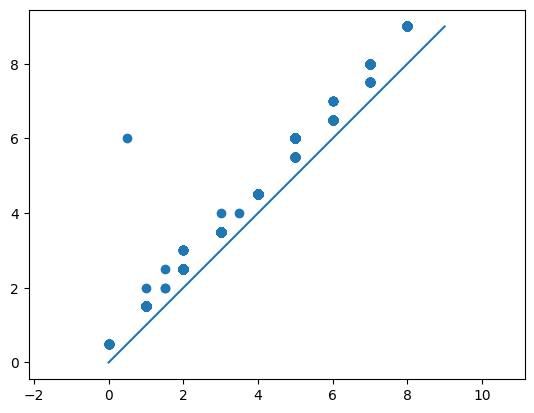

In [15]:
#d.plot.plot_diagram(dgms[0], show = True)
d.plot.plot_diagram(dgms[1], show = True)